In [2]:
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import preprocessing
from accuracy import RPrecision

import collections

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data_path = "../data" ## TODO: Maybe edit if need be?

In [5]:
## get the tokenized list of words from the corpus
train_tracks_id, test_tracks_id, track_to_id, relevance_output = preprocessing.preprocess()

## A useful utility for counting things
word_counter = collections.Counter(train_tracks_id)

## What are the 40 most common words?
n_most_common = 40
most_common_tokens, most_common_occurrences = zip(*word_counter.most_common(n_most_common))

## Convert the tokens back to words so that we can see what they are
token_to_word_dict = {i:w for w, i in track_to_id.items()}
most_common_words = [token_to_word_dict[t] for t in most_common_tokens]

print(*zip(most_common_words, most_common_occurrences), sep = ", ")

('<BREAK>', 2000), ('Closer', 136), ('Roses', 98), ('One Dance', 98), ('HUMBLE.', 96), ('Home', 94), ('Congratulations', 90), ('Ride', 87), ('Broccoli (feat. Lil Yachty)', 87), ('Bad and Boujee (feat. Lil Uzi Vert)', 84), ('Caroline', 83), ('Forever', 75), ('Let Me Love You', 74), ('XO TOUR Llif3', 73), ('Sorry', 73), ('Panda', 73), ('Mask Off', 72), ('Selfish', 70), ('goosebumps', 70), ('Starboy', 70), ('Down', 67), ('iSpy (feat. Lil Yachty)', 67), ('Skinny Love', 67), ('Gold', 67), ('White Iverson', 67), ('Stay', 66), ("Don't Let Me Down", 65), ('Trap Queen', 65), ('Location', 65), ('Jumpman', 64), ('1-800-273-8255', 63), ('Mercy', 63), ('Black Beatles', 63), ('Redbone', 62), ('T-Shirt', 62), ('Shape of You', 62), ('Waves', 62), ('No Problem (feat. Lil Wayne & 2 Chainz)', 62), ('Riptide', 61), ('No Role Modelz', 61)


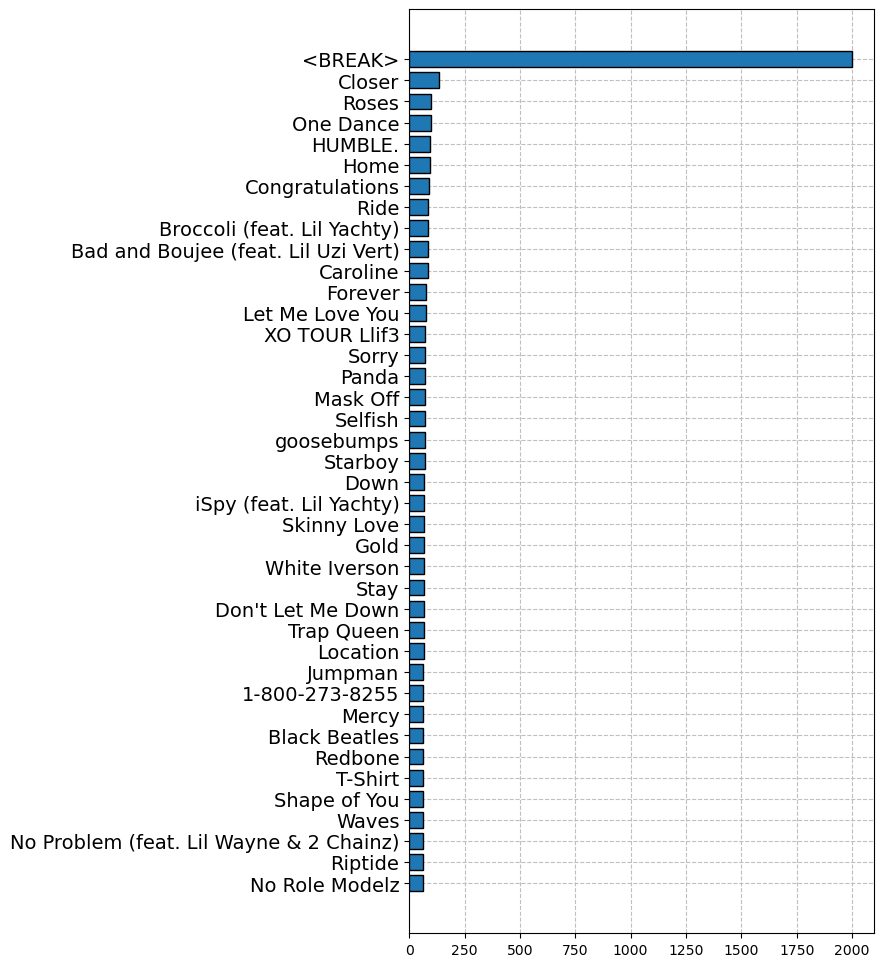

In [6]:
fig_most_common, ax_top50_most_common = plt.subplots()
ax_top50_most_common.barh(y = most_common_words,
                          width = most_common_occurrences, 
                          height = 0.75, 
                          color = "C0", 
                          edgecolor = "black", 
                          zorder = 100)

ax_top50_most_common.grid(linestyle = "dashed", 
                          color = "#bfbfbf", 
                          zorder = -100)

ax_top50_most_common.set_yticks(ticks = ax_top50_most_common.get_yticks())
ax_top50_most_common.set_yticklabels(labels = most_common_words, 
                                     fontsize = 14)

ax_top50_most_common.invert_yaxis()
## If you want log-scale 
# ax_top50_most_common.set_xscale('log')

fig_most_common.set_size_inches([6, 12])

In [7]:
%%time

import rnn

train_tracks_id, test_tracks_id, track_to_id, relevance_output = preprocessing.preprocess()

train_id = np.array(train_tracks_id)
test_id  = np.array(test_tracks_id)
X0, Y0 = train_id[:-1], train_id[1:]
X1, Y1  = test_id[:-1],  test_id[1:]


X0 = X0[:-(len(X0) % 20)]
Y0 = Y0[:-(len(Y0) % 20)]
X1 = X1[:-(len(X1) % 20)]
Y1 = Y1[:-(len(Y1) % 20)]

np.reshape(X0, (-1, 20))
np.reshape(X1, (-1, 20))
np.reshape(Y0, (-1, 20))
np.reshape(Y1, (-1, 20))

rnn_args = rnn.get_text_model(train_tracks_id)

rnn_args.model.fit(
    X0, Y0,
    epochs=rnn_args.epochs,
    batch_size=rnn_args.batch_size,
    validation_data=(X1, Y1)
)

1336/1336 [==============================] - 1201s 897ms/step - loss: 10.7942 - perplexity: 50960.5312 - val_loss: 9.8561 - val_perplexity: 21700.8789
CPU times: total: 2h 5min 10s
Wall time: 39min 51s


In [8]:
## Feel free to mess around with the word list to see the model try to generate sentences
for word1 in ["Say It Ain't So", "Island In The Sun", "Undone - The Sweater Song"]:
    if word1 not in track_to_id: print(f"{word1} not in vocabulary")            
    else: print(rnn_args.model.generate_sentence(word1, 20, track_to_id, 10))
    print("")

["Say It Ain't So", 'Let Me Love You', 'XO TOUR Llif3', 'No Problem (feat. Lil Wayne & 2 Chainz)', 'Closer', 'Closer', "F**kin' Problems", 'Despacito - Remix', 'One Dance', '<BREAK>', 'Closer', "Don't Let Me Down", "Don't Let Me Down", 'Mask Off', 'XO TOUR Llif3', 'iSpy (feat. Lil Yachty)', "Don't Let Me Down", 'iSpy (feat. Lil Yachty)', 'Mask Off', 'Mask Off', 'One Dance']

['Island In The Sun', 'Let Me Love You', '<BREAK>', 'Closer', '<BREAK>', 'No Problem (feat. Lil Wayne & 2 Chainz)', "Don't Let Me Down", 'Broccoli (feat. Lil Yachty)', '<BREAK>', 'No Problem (feat. Lil Wayne & 2 Chainz)', 'Hotline Bling', 'White Iverson', '<BREAK>', "Don't Let Me Down", '<BREAK>', 'Closer', 'Home', '<BREAK>', "F**kin' Problems", 'iSpy (feat. Lil Yachty)', "Don't Let Me Down"]

['Undone - The Sweater Song', "F**kin' Problems", 'iSpy (feat. Lil Yachty)', 'No Problem (feat. Lil Wayne & 2 Chainz)', 'Me, Myself & I', 'Broccoli (feat. Lil Yachty)', '<BREAK>', "That's What I Like", 'Whatever You Like', '<

In [9]:
##Gets total accuracy
avgacc = 0.0
index = 0
for song in track_to_id:
    l1 = [track_to_id[x] for x in rnn_args.model.generate_sentence(song, 20, track_to_id, 10)]
    print(l1)
    l2 = relevance_output[track_to_id[song]]
    print(l2)
    avgacc = avgacc + RPrecision.call(l1, l2)
    index += 1
    if(index % 50 == 0):
        print(avgacc / index)

avgacc = avgacc / len(track_to_id)
print(avgacc)


[0, 7736, 8301, 5804, 28946, 7736, 12614, 10509, 28946, 18044, 8301, 18044, 46506, 10509, 39213, 766, 8301, 7736, 766, 23569, 23569]
[4091, 47750, 21078, 8083, 13276, 12960, 45737, 23312, 13825, 16684, 15816, 20603, 27735, 33878, 18149, 18118, 48355, 29350, 29751, 25161, 20627, 0]
[1, 17812, 766, 23569, 766, 17812, 10509, 28946, 26351, 10509, 10509, 26113, 47427, 46024, 23569, 47427, 48604, 48604, 7736, 15432, 26351]
[10348, 30086, 15884, 17652, 18826, 16347, 3953, 18454, 16899, 5507, 35009, 10605, 34271, 12777, 12776, 37715, 5538, 582, 44237, 18745, 25948, 42327, 23686, 13525, 29932, 41758, 41836, 19355, 46782, 47670, 5643, 38720, 7928, 29905, 40135, 5102, 16342, 4970, 2357, 22439, 1360, 1596, 35452, 8103, 3409, 2885, 20569, 1230, 2105, 27079, 36786, 32440, 12485, 8708, 41670, 3094, 31666, 17536, 15755, 36473, 46165, 31284, 19910, 6724, 28061, 23437, 38541, 28099, 5502, 44778, 20233, 954, 42683, 27906, 20758, 37519, 23175, 30564, 12466, 42688, 12005, 35587, 41659, 19500, 24600, 41065,

KeyError: 766